# 3REQ system

Requirement analysis system.

The flow is presented in the following figure: 

![The flow of this script \label{mylabel}](./flow.png)


In [1]:
from docx2python import docx2python
import os

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

In [2]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Step 1: List the documents's sections with "latency"

In the first step, we go through the documents in the folder "input_standards" and we extract which sections of these documents contain th word "latency". We store the results in a dictionary.

In [3]:
def extractLatencySections(doc):
    strSectionTitle = ""
    dictSections = {}
    listLatency = []

    doc_result = docx2python(doc,paragraph_styles = True, html=True)

    # we iterate over all lines
    # look for the section titles (which have the tag <h1>, <h2>, <h3>, etc.)
    # then we add the content of each section to the dictionary
    # and if there is a word "latency" somewhere in the section, we add the section title to the listLatency
    for oneLine in doc_result.text.split('\n'):
        if "<h" in oneLine:
            strSectionTitle = oneLine
            dictSections[strSectionTitle] = []

        if strSectionTitle != "":  
            dictSections[strSectionTitle].append(oneLine)

        keywordsInLine = ["latency", "latencies", "delay"]
        keywordsInSections = ["references", "introduction"]

        if any(word in oneLine.lower() for word in keywordsInLine) and not any(word in strSectionTitle.lower() for word in keywordsInSections): 
            listLatency.append(strSectionTitle)

            
    # remove the keys from the dictionary if they are not part of the listLatency
    # as we want to get only the relevant sections, i.e., the one with the word latency
    for key in list(dictSections.keys()):
        if key not in listLatency:
            del dictSections[key]

    # return the dictionary with the relevant sections
    return dictSections


In [4]:
docInputFolder = "./input_standards"

# this is the return list of all the lines in the document
lstAllLines = []

# for each .docx file in the input folder
# extract the sections with latency using the extractLatencySections function
# and print the sections
for doc in os.listdir(docInputFolder):    

    if doc.endswith(".docx"):
        print(f"Processing {doc}")

        # since things can go wrong with the latency library, 
        # we use a try except block to avoid the program to stop
        try: 
            dictSections = extractLatencySections(os.path.join(docInputFolder, doc))
        
            # we list the content
            # as a long list of sections 
            for key in dictSections:

                lstOneLine = [key, doc]

                for line in dictSections[key]:
                    lstOneLine.append(line)
                    
                lstAllLines.append(lstOneLine)

        except Exception as e:
            print(f"Error with {doc}: {e}")

Processing 23003-i20.docx
Processing 23007-i20.docx
Processing 23007-i21.docx
Processing 23032-i00.docx
Processing 23038-i00.docx
Processing 23122-i30.docx
Processing 23122-i31.docx
Processing 23122-i32.docx
Processing 23167-i10.docx
Processing 23216-i00.docx
Processing 23228-i20.docx
Processing 23247-i20.docx
Processing 23256-i10.docx
Processing 23273-i20.docx
Processing 23280-i60.docx
Processing 23281-i40.docx
Processing 23282-i40.docx
Processing 23283-i10.docx
Processing 23287-i00.docx
Processing 23288-i20.docx
Processing 23289-i60.docx
Processing 23304-i20.docx
Processing 23316-i20.docx
Processing 23379-i60.docx
Processing 23401-i20.docx
Processing 23402-i20.docx
Processing 23433-i00.docx
Processing 23434-i50.docx
Processing 23435-i00.docx
Processing 23436-i00.docx
Processing 23501-i22.docx
Processing 23502-i20.docx
Processing 23503-i20.docx
Processing 23527-i00.docx
Processing 23540-i00.docx
Processing 23542-i00.docx
Processing 23548-i20.docx
Processing 23554-i40.docx
Processing 2

In [5]:
model = SentenceTransformer("all-MiniLM-L6-v2")

# list with all embeddings for the sections
lstEmbeddings = []

for oneLine in lstAllLines:

    # the content of the section starts on the third position of the list
    sentences = oneLine[3:]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embedding = np.mean(embeddings, axis=0)
    
    lstOneLine = [oneLine[0], oneLine[1], 2, str(sentences).replace("$", "_").replace("\n", "_"), avg_embedding]

    lstEmbeddings.append(lstOneLine)


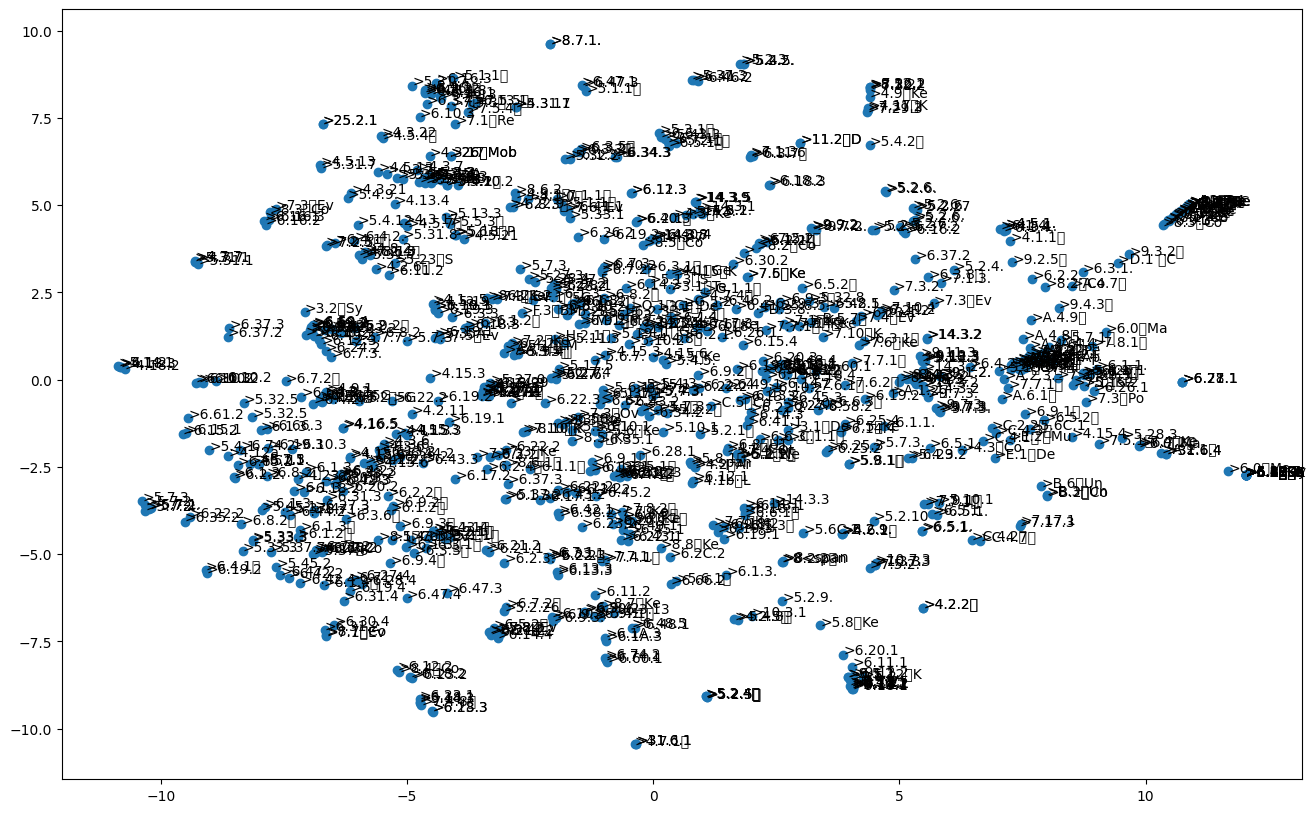

In [6]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[4] for x in lstEmbeddings])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1])

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddings]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[3:10])


plt.show()

## Step 2: Find the relevant sections

In this step, we take the sections identified in Step 1 and we compare them to a list of right and wrong requirements. The list is stored in the file List.xlsx

In [7]:
# open the file List.xlsx using pandas
# and read the workshop NR
df = pd.read_excel("List.xlsx", sheet_name="R_NR")

# convert the dataframe to a list of lists
lstReference = df.values.tolist()

lstReference[0]

['The 5G system shall support an end-to-end latency of less than 5 ms or 10 ms, as requested by the UE initiating the communication.',
 1]

In [8]:
# list with all embeddings for the sections
lstEmbeddingsRef = []

for oneLine in lstReference:

    # the content of the section starts on the third position of the list
    sentences = oneLine[0]

    # Sentences are encoded by calling model.encode()
    embeddings = model.encode(sentences)
    
    # Print the average embeddings for all the sentences 
    # in this section
    avg_embedding = embeddings
    
    lstOneLine = [oneLine[0], 'REF', oneLine[1], oneLine[1], avg_embedding]

    lstEmbeddingsRef.append(lstOneLine)

In [9]:
# concatenate the two lists
lstEmbeddingsAll = lstEmbeddings + lstEmbeddingsRef

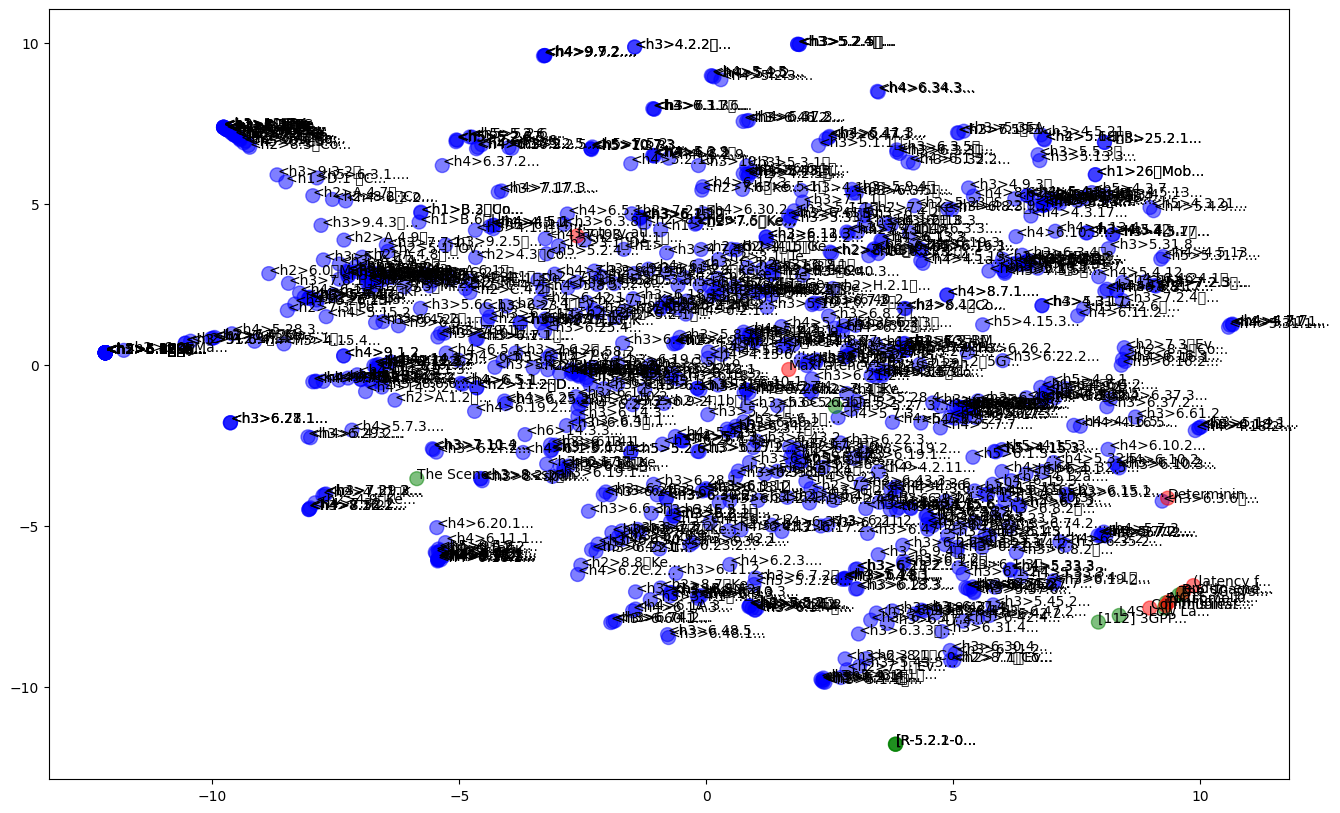

In [10]:
# let's plot these average embeddings using t-SNE

# we create a list with the embeddings
lstEmbeddingsNP = np.array([x[4] for x in lstEmbeddingsAll])

# we use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(lstEmbeddingsNP)

# Create a color map based on x[2]
color_map = {0: 'red', 1: 'green', 2: 'blue'}
colors = [color_map[x[2]] for x in lstEmbeddingsAll]

# we plot the t-SNE results
plt.figure(figsize=(16,10))

plt.scatter(tsne_results[:,0], tsne_results[:,1],c=colors, s=100, alpha=0.5)

# Add labels to each dot
for i, label in enumerate([x[0] for x in lstEmbeddingsAll]):
    plt.text(tsne_results[i, 0], tsne_results[i, 1], label[:10]+'...')


plt.show()

In [11]:
from sklearn.metrics.pairwise import euclidean_distances

# for each line in lstEmbeddings
# we calculate the euclidean distance with each line in lstEmbeddingsRef

lstDistPos = []
lstDistNeg = []

lstRelevant = []

for oneLine in lstEmbeddings:    
    for oneLineRef in lstEmbeddingsRef:
        if oneLineRef[2] == 1:
            # euclidean distance between the two embeddings
            dist = euclidean_distances([oneLine[4]], [oneLineRef[4]])
            lstDistPos.append(dist[0][0])
        if oneLineRef[2] == 0:
            # euclidean distance between the two embeddings
            dist = euclidean_distances([oneLine[4]], [oneLineRef[4]])
            lstDistNeg.append(dist[0][0])
    
    # now calculate the average for both lists
    avgDistPos = np.mean(lstDistPos)
    avgDistNeg = np.mean(lstDistNeg)

    if avgDistPos < avgDistNeg:
        #print(f"Section {oneLine[0]} is relevant")
        # add the class to the list
        oneLine.append(1)
        lstRelevant.append(oneLine)
    else:
        #print(f"Section {oneLine[0]} is not relevant")
        # add the class to the list
        oneLine.append(0)

                

In [12]:
# here we save all the relevant sections to an Excel file
# and the non-relevant ones too
import pandas as pd

dfOutput = pd.DataFrame(lstEmbeddings, columns=["Section", "Document", "Class", "Content", "Embedding", "Relevance"])

dfOutput.to_excel("./output.xlsx", index=False)

## Step 3: Find which requirements are impacted

In this step, we compare the relevant sections with the existing requirements. Based on the distance, we can determine which requirements are impacted. The requirements are provided as a separete list. 

In [13]:
print(f'Percentage relevant: {len(lstRelevant)/len(lstEmbeddings)*100:.2f}%')

Percentage relevant: 100.00%


In [14]:
# read the requirements from the excel file requirements.xlsx, worksheet LR
df = pd.read_excel("List.xlsx", sheet_name="LR")

# convert to list
lstRequirements = df.values.tolist()
lstRequirements[0]

# now we calculate the embeddings for each of these requirements
lstEmbeddingsReq = []

for oneLine in lstRequirements:
    
        # the content of the section starts on the third position of the list
        sentences = oneLine[1]
    
        # Sentences are encoded by calling model.encode()
        embeddings = model.encode(sentences)
        
        # Print the average embeddings for all the sentences 
        # in this section
        avg_embedding = embeddings
        
        lstOneLine = [oneLine[0], 'latency', oneLine[1], oneLine[1], avg_embedding]
    
        lstEmbeddingsReq.append(lstOneLine)

In [15]:
# now we calculate the euclidean distance between the requirements and the sections
# that are relevant
lstDist = []
lstRelevantDist = []

for oneLine in lstRelevant:
    for oneLineReq in lstEmbeddingsReq:
        # euclidean distance between the two embeddings
        dist = euclidean_distances([oneLine[4]], [oneLineReq[4]])
        lstDist.append([oneLine[0], oneLine[1], oneLineReq[0], dist[0][0], oneLine[3]])

# now we sort the list by the distance
lstDist.sort(key=lambda x: x[2])

# and we print them
for i in range(len(lstDist)):
    print(f"Section {lstDist[i][0]} is close to requirement {lstDist[i][2]} with distance {lstDist[i][3]:.2f}")
    # add this to a list
    lstRelevantDist.append([lstDist[i][0], lstDist[i][1], lstDist[i][2], lstDist[i][3], lstDist[i][4]])

# save the list to an Excel file
dfOutput = pd.DataFrame(lstRelevantDist, columns=["Section", "Document", "Requirement", "Distance", "Content"])

# sort it by section and document
dfOutput = dfOutput.sort_values(by=["Section", "Document"])

dfOutput.to_excel("./output_requirements_distances_b.xlsx", index=False)

Section <h3>4.2.2	Mobile Terminated Short Message</h3> is close to requirement LR1_signalling with distance 1.10
Section <h3>5.2.4	Procedures in the SGSN</h3> is close to requirement LR1_signalling with distance 1.11
Section <h3>5.2.5	Procedures in the MME</h3> is close to requirement LR1_signalling with distance 1.08
Section <h3>25.2.1	General</h3> is close to requirement LR1_signalling with distance 1.06
Section <h1>26	Mobile terminated CS service delivery via an alternative MME in MME pool</h1> is close to requirement LR1_signalling with distance 1.03
Section <h3>31.6.1	General</h3> is close to requirement LR1_signalling with distance 1.09
Section <h3>31.6.4	Restoration of PFCP sessions associated with an FQ-CSID, Group ID or PGW-C/SMF IP Address</h3> is close to requirement LR1_signalling with distance 1.25
Section <h3>4.2.2	Mobile Terminated Short Message</h3> is close to requirement LR1_signalling with distance 1.10
Section <h3>5.2.4	Procedures in the SGSN</h3> is close to requir

In [16]:
# average the distance in dfOutput per section, document and requirement
dfOutput["Distance"] = dfOutput["Distance"].astype(float)
dfGrouped = dfOutput.groupby(["Section", "Document", "Requirement", "Content"])

#convert dfGrouped to a dataframe
dfGrouped = dfGrouped.agg({"Distance": "mean"}).reset_index()

dfGrouped.to_excel("./output_requirements_distances_g.xlsx", index=False)

In [18]:
# now check the minimum distance per section and document
dfGrouped = dfGrouped.sort_values(by=["Section", "Document", "Distance"])

dfGrouped = dfGrouped.groupby(["Section", "Document"]).first().reset_index()

dfGrouped.to_excel("./output_requirements_distances_g_min.xlsx", index=False)

Section           Document  \
0                                                 <h1>  23700-25-i10.docx   
1                                                 <h1>  23700-27-i00.docx   
2                                                 <h1>  23700-53-i00.docx   
3                                                 <h1>  23700-60-i00.docx   
4                                                 <h1>  23700-71-i00.docx   
..                                                 ...                ...   
870  <h5>8.6.6.3.4\tSession with QoS update request...     23558-i30.docx   
871  <h5>9.12.2.1.1\tSlice related Communication Se...     23435-i00.docx   
872  <h5>9.5.2.1.1\tVAL server policy provisioning ...     23435-i00.docx   
873                   <h6>14.3.3.4.1.2\tProcedure</h6>     23434-i50.docx   
874                 <h6>7.27.2.2.1.1\tDescription</h6>  23700-98-i10.docx   

        Requirement                                            Content  \
0    LR1_signalling  ['1\tScope</h1>', '', 'The objective of this T...   
1       LR2_payload  ['1\tScope</h1>', '', 'The scope of this Techn...   
2    LR1_signalling  ['1\tScope</h1>', '', 'The purpose of this Tec...   
3       LR2_payload  ['1\tScope</h1>', '', 'The Technical Report st...   
4    LR1_signalling  ['1\tScope</h1>', '', 'The scope of this Techn...   
..              ...                                                ...   
870  LR1_signalling  ['', 'Table\xa08.6.6.3.4-1 describes the infor...   
871  LR1_signalling  ['', 'Figure 9.12.2.1.1-1 illustrates the proc...   
872  LR1_signalling  ['', 'Figure 9.5.2.1.1 illustrates the procedu...   
873  LR1_signalling  ['', 'Figure\xa014.3.3.4.1.2-1 illustrates the...   
874  LR1_signalling  ['', 'The AC association Profile (AAP) is prop...   

     Distance  
0    0.996952  
1    1.034579  
2    1.076281  
3    1.046257  
4    1.033890  
..        ...  
870  1.107623  
871  1.080076  
872  1.039280  
873  1.061216  
874  1.156418  

[875 rows x 5 columns]

In [19]:
# now we turn this into a list of lists
lstRelevantDist = dfGrouped.values.tolist()

print(len(lstRelevantDist))

875


## Step 4: create requirements based on each of these sections

In the last step, we create new requirements based on the sections identified in the previous steps.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

modelInstr = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizerInstr = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

In [ ]:
def createRequirement(content, type, model, tokenizer):
    
    strContent = f"Write the requirement in the following format 'The {type} of the system shall' {content}"

    messages = [
        {"role": "user", "content": strContent},
    ]

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
    )

    generation_args = {
        "max_new_tokens": 500,
        "return_full_text": False,
        "temperature": 0.0,
        "do_sample": False,
    }

    output = pipe(messages, **generation_args)
    
    return output[0]['generated_text']